# Временные ряды

**Временной ряд** — значения меняющихся во времени признаков, полученные в некоторые моменты времени.

# Методы для проверки на стационарность

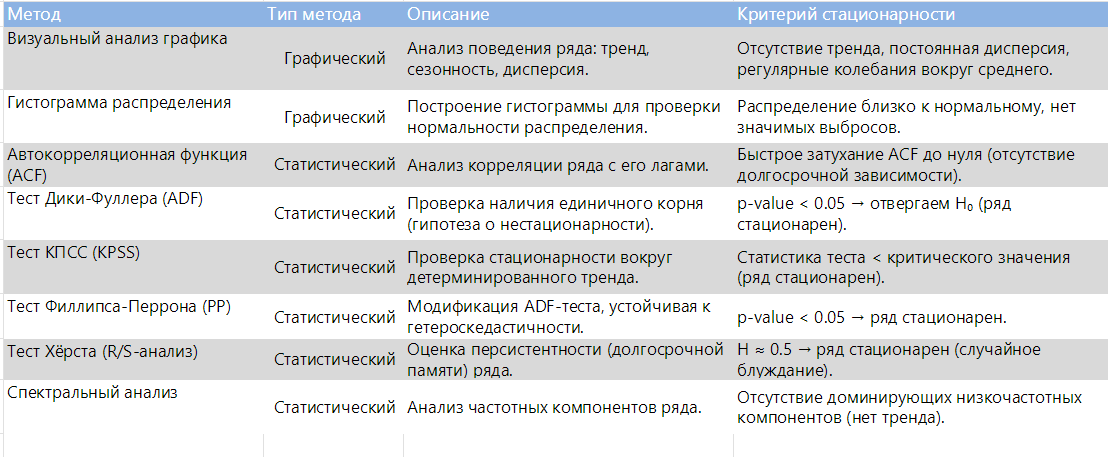

# Автокорреляционная функция (ACF)

In [22]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<Axes: title={'center': 'Число пассажиров'}>

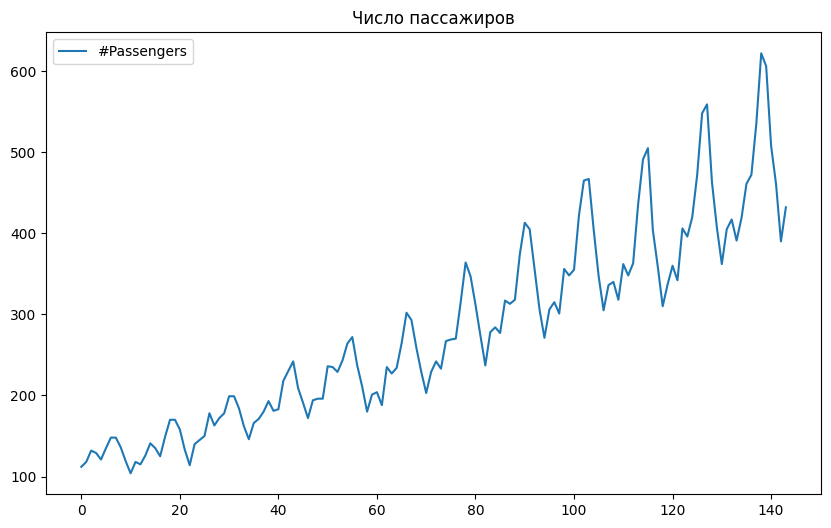

In [12]:
path = 'https://www.dropbox.com/s/cdjjafehpd0tmbw/AirPassengers.csv?dl=1'
data = pd.read_csv(path)
data.plot(figsize=(10, 6), title='Число пассажиров')


In [24]:
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


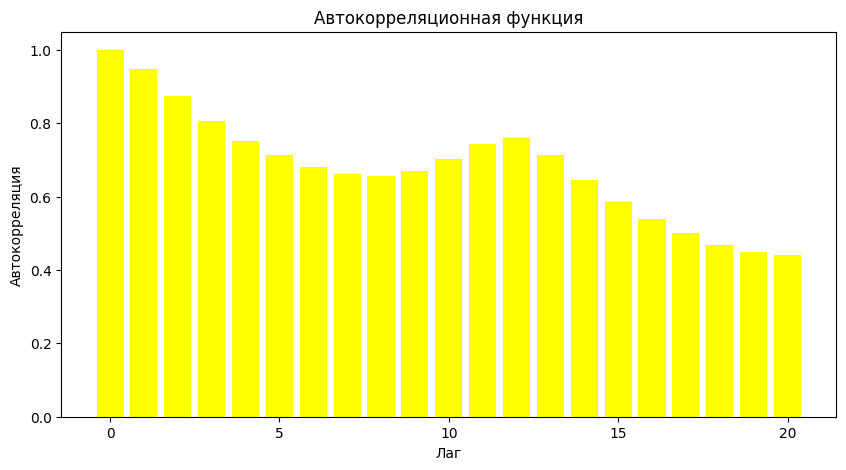

In [26]:
lags = 20  # Количество лагов для анализа
acf_values = acf(data['#Passengers'], nlags=lags)

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(range(lags + 1), acf_values, color='yellow')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.title('Автокорреляционная функция')
plt.show()

Если значения ACF быстро затухают, ряд может быть стационарным.

Если ACF медленно убывает, ряд может содержать тренд или быть нестационарным.

# Тест Дики-Фуллера (ADF)

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

In [18]:
import statsmodels.tsa.stattools as ts
dir(ts)


['ArrayLike1D',
 'Bunch',
 'CollinearityWarning',
 'InfeasibleTestError',
 'InterpolationWarning',
 'LinAlgError',
 'Literal',
 'MissingDataError',
 'OLS',
 'SQRTEPS',
 'Union',
 'ValueWarning',
 'ZivotAndrewsUnitRoot',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_autolag',
 '_kpss_autolag',
 '_next_regular',
 '_safe_arma_fit',
 '_sigma_est_kpss',
 'acf',
 'acovf',
 'add_constant',
 'add_trend',
 'adfuller',
 'annotations',
 'arma_order_select_ic',
 'array_like',
 'bds',
 'bool_like',
 'breakvar_heteroskedasticity_test',
 'ccf',
 'ccovf',
 'coint',
 'correlate',
 'deprecate_kwarg',
 'dict_like',
 'float_like',
 'grangercausalitytests',
 'has_missing',
 'innovations_algo',
 'innovations_filter',
 'int_like',
 'interp1d',
 'kpss',
 'lagmat',
 'lagmat2ds',
 'levinson_durbin',
 'levinson_durbin_pacf',
 'lstsq',
 'lzip',
 'mackinnoncrit',
 'mackinnonp',
 'np',
 'pacf',
 'pacf_burg',
 'pacf_ols',
 'pacf_yw',


In [33]:
result = adfuller(data['#Passengers'], autolag='AIC')
print('Критерий ADF:', result[0])
print('P-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

if  result[1] <= 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

Критерий ADF: 0.8153688792060498
P-значение: 0.991880243437641
Критические значения:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Ряд нестационарен (не отвергаем H0)


Если P-значение меньше 0.05, то нулевая гипотеза отвергается, и ряд считается стационарным.

Если P-значение больше 0.05, то нулевая гипотеза не отвергается, и ряд не стационарен.

# Тест КПСС (KPSS)

In [46]:
result = kpss(data['#Passengers'])
print('Критерий PP:', result[0])
print('P-значение:', result[1])

if  result[1] >= 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

Критерий PP: 1.6513122354165206
P-значение: 0.01
Ряд нестационарен (не отвергаем H0)


<ipython-input-46-aac6e2b28a3f>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data['#Passengers'])


# Тест Филлипса-Перрона (PP)

In [37]:
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import acorr_lm
from scipy.stats import norm

def phillips_perron_test(series, lags=None):
    series = pd.Series(series).dropna()  # Убедимся, что это Series и нет пропусков
    n = len(series)

    # Создаем лагированную переменную
    y_lag = series.shift(1).dropna()
    y_diff = series.diff().dropna()

    # Выравниваем данные по индексам
    y_diff = y_diff[y_diff.index.isin(y_lag.index)]
    y_lag = y_lag[y_lag.index.isin(y_diff.index)]

    # Добавляем константу и тренд
    X = pd.DataFrame({
        'const': 1,
        'trend': np.arange(len(y_lag)),
        'y_lag': y_lag
    })

    # Оцениваем регрессию
    model = OLS(y_diff, X).fit()
    resid = model.resid

    # Автоматический выбор лагов, если не задан
    if lags is None:
        lags = int(4 * (n / 100) ** (2 / 9)) if n > 100 else 4

    # Оценка долгосрочной дисперсии (Newey-West)
    sigma2 = np.var(resid, ddof=1)
    s2 = sigma2 * (n / (n - model.df_model))

    # PP-статистика
    pp_stat = (model.params['y_lag'] - 1) / model.bse['y_lag'] - 0.5 * (s2 - sigma2) / (s2 ** 0.5)

    # P-значение
    p_value = 2 * (1 - norm.cdf(abs(pp_stat)))  # Двусторонний тест

    return pp_stat, p_value

In [40]:
pp_stat, p_value = phillips_perron_test(data['#Passengers'], 20)
print(f"PP-статистика: {pp_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

if p_value <= 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

PP-статистика: -22.1572
P-значение: 0.0000
Ряд стационарен (отвергаем H0)


# Тест Хёрста (R/S-анализ)

In [41]:
def hurst_exponent(ts, max_lag=100):
    lags = range(2, max_lag)
    tau = [np.std(ts[:lag]) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

# Вычисление показателя Херста
hurst = hurst_exponent(data['#Passengers'])
print(f'Показатель Херста: {hurst:.3f}')

Показатель Херста: 0.746


In [42]:
if hurst < 0.49:
    print("Ряд антиперсистентен (имеет тенденцию к смене направления)")
elif hurst > 0.49:
    print("Ряд персистентен (имеет долгосрочную зависимость)")
else:
    print("Ряд представляет собой случайное блуждание")

Ряд персистентен (имеет долгосрочную зависимость)


Если H ≈ 0.5, то ряд представляет собой случайное блуждание.

Если H < 0.5, то ряд антиперсистентен (имеет тенденцию к смене направления).

Если H > 0.5, то ряд персистентен (имеет долгосрочную зависимость).

# Спектральный анализ

In [34]:
from scipy.fftpack import fft

In [44]:
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data['Time_Step'] = data['Month'].diff().dt.days

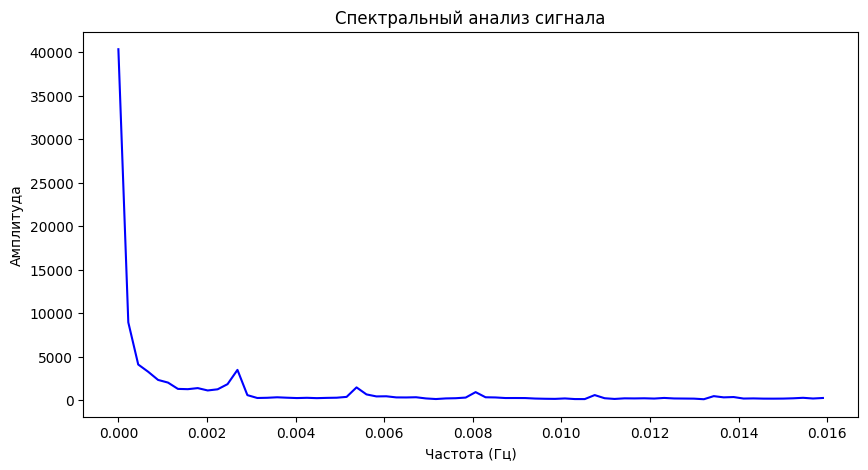

In [45]:
N = len(data['#Passengers'])  # Количество точек
freqs = np.fft.fftfreq(N, d=data['Time_Step'][1])  # Частоты
fft_values = np.fft.fft(data['#Passengers'])  # Преобразование Фурье

# Визуализация спектра
plt.figure(figsize=(10, 5))
plt.plot(freqs[:N//2], np.abs(fft_values[:N//2]), color='blue')
plt.xlabel('Частота (Гц)')
plt.ylabel('Амплитуда')
plt.title('Спектральный анализ сигнала')
plt.show()

Интерпретация графика

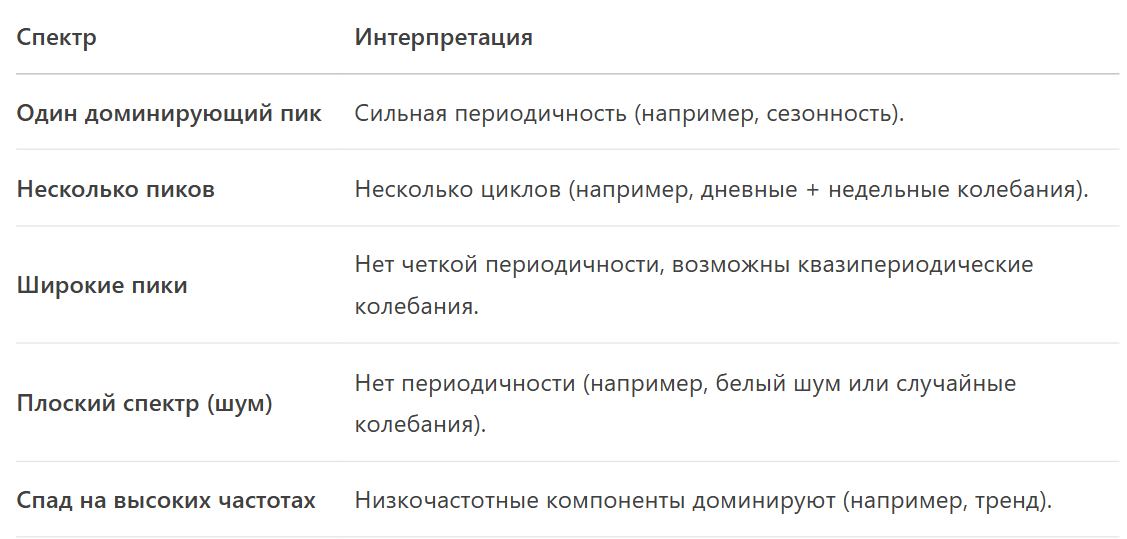

# Методы приведения к стационарнисти

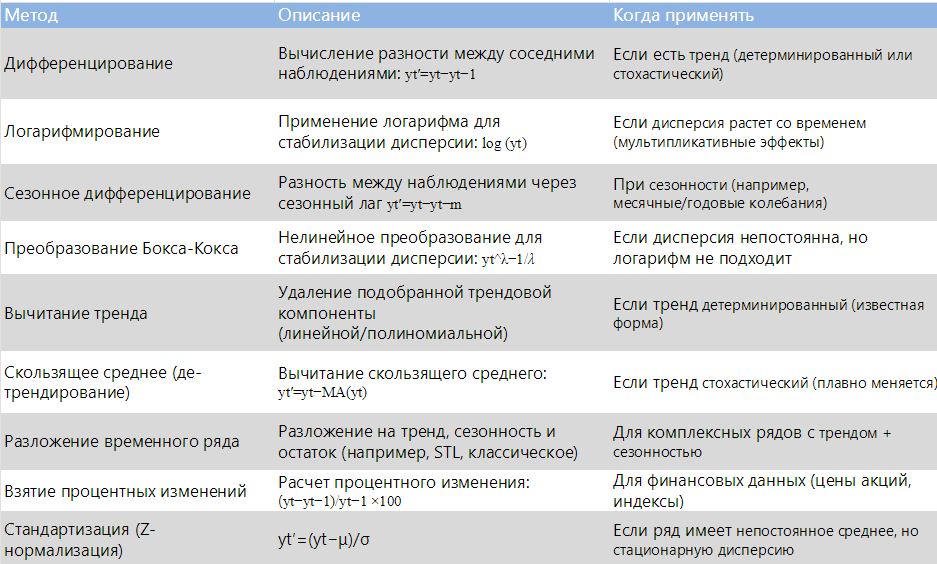

Как выбрать метод?
1. Если есть тренд → дифференцирование (1) или вычитание тренда (5).

2. Если есть сезонность → сезонное дифференцирование (3) или разложение (7).

3. Если дисперсия непостоянна → логарифмирование (2) или Бокс-Кокс (4).

4. Для финансовых данных → процентные изменения (8).

In [47]:
df = data

In [48]:
#Дифференцирование
df['diff'] = df['#Passengers'].diff().dropna()

#Сезонное дифференцирование
df['seasonal_diff'] = df['#Passengers'].diff(12).dropna()

In [49]:
#Логарифмирование
df['log'] = np.log(df['#Passengers'])

In [50]:
#Преобразование Бокса-Кокса
from scipy.stats import boxcox
df['boxcox'], _ = boxcox(df['#Passengers'])

In [52]:
#Скользящее среднее MA
df['ma'] = df['#Passengers'] - df['#Passengers'].rolling(12).mean()

In [56]:
#Разложение временного ряда
from statsmodels.tsa.seasonal import STL
res = STL(df['#Passengers'],  period=12).fit()

In [54]:
#Взятие процентных изменений
df['pct_change'] = df['#Passengers'].pct_change() * 100

In [57]:
#Стандартизация (Z-нормализация)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(df[['#Passengers']])

array([[-1.40777884],
       [-1.35759023],
       [-1.24048348],
       [-1.26557778],
       [-1.33249593],
       [-1.21538918],
       [-1.10664719],
       [-1.10664719],
       [-1.20702441],
       [-1.34922546],
       [-1.47469699],
       [-1.35759023],
       [-1.38268454],
       [-1.29067209],
       [-1.16520057],
       [-1.21538918],
       [-1.29903686],
       [-1.09828242],
       [-0.9226223 ],
       [-0.9226223 ],
       [-1.02299951],
       [-1.23211871],
       [-1.3910493 ],
       [-1.17356534],
       [-1.1317415 ],
       [-1.08991766],
       [-0.85570415],
       [-0.98117567],
       [-0.90589276],
       [-0.85570415],
       [-0.68004402],
       [-0.68004402],
       [-0.80551554],
       [-0.98954044],
       [-1.12337673],
       [-0.95608137],
       [-0.91425753],
       [-0.83897462],
       [-0.73023263],
       [-0.83060985],
       [-0.81388031],
       [-0.52111343],
       [-0.42073621],
       [-0.320359  ],
       [-0.59639634],
       [-0

In [58]:
df

,Month,#Passengers,Time_Step,diff,seasonal_diff,log,boxcox,ma,pct_change
0,1949-01-01,112,NaN,NaN,NaN,4.718499,6.827488,NaN,NaN
1,1949-02-01,118,31.0,6.0,NaN,4.770685,6.932820,NaN,5.357143
2,1949-03-01,132,28.0,14.0,NaN,4.882802,7.161889,NaN,11.864407
3,1949-04-01,129,31.0,-3.0,NaN,4.859812,7.114609,NaN,-2.272727
4,1949-05-01,121,30.0,-8.0,NaN,4.795791,6.983785,NaN,-6.201550
...,...,...,...,...,...,...,...,...,...
139,1960-08-01,606,31.0,-16.0,47.0,6.406880,10.684045,142.666667,-2.572347
140,1960-09-01,508,31.0,-98.0,45.0,6.230481,10.234569,40.916667,-16.171617
141,1960-10-01,461,30.0,-47.0,54.0,6.133398,9.992156,-10.583333,-9.251969
142,1960-11-01,390,31.0,-71.0,28.0,5.966147,9.582619,-83.916667,-15.401302


# ARIMA

Модель ARIMA(p,d,q) — это расширение моделей типа ARMA на нестационарные временные ряды, которые однако могут стать стационарным после применениея процедуры дифференцирования ряда.

AR(p) — авторегрессия порядка p (зависимость от предыдущих значений).

I(d) — дифференцирование порядка d (устранение нестационарности).

MA(q) — скользящее среднее порядка q (зависимость от прошлых ошибок).

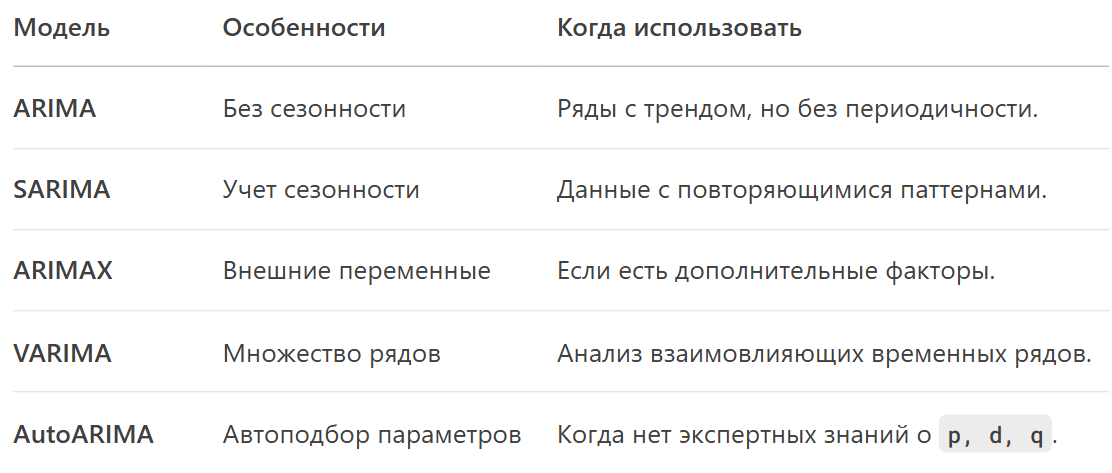

0.991880243437641


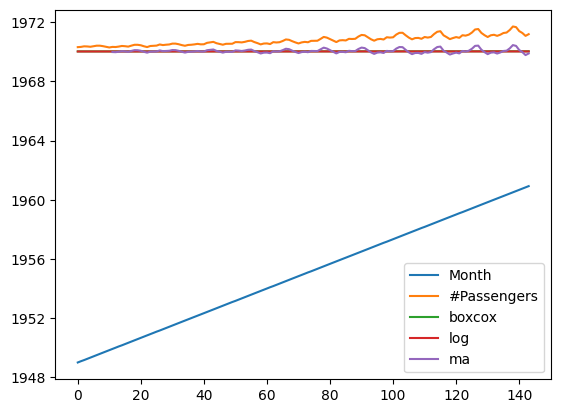

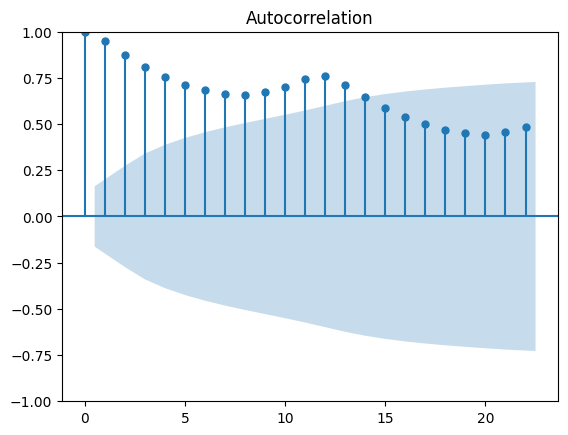

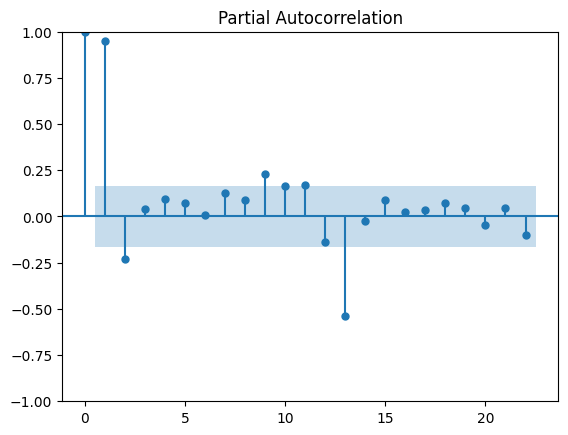

In [90]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 2. Визуальный анализ
data.plot()
plot_acf(data['#Passengers'])  # для выбора q
plot_pacf(data['#Passengers']) # для выбора p

# 3. Тест на стационарность
print(adfuller(data['#Passengers'])[1])  # если p > 0.05 → дифференцировать

#data['ma'] = data['#Passengers'] - data['#Passengers'].rolling(12).mean()

# 4. Подбор параметров
model = ARIMA(data['#Passengers'], order=(2, 1, 1))
results = model.fit()

# 5. Прогноз
forecast = results.forecast(steps=10)

In [91]:
forecast

,predicted_mean
144,471.000383
145,492.998177
146,497.918890
147,492.528738
148,484.243730
149,477.843463
150,474.914377
151,474.849500
152,476.211067
153,477.727786


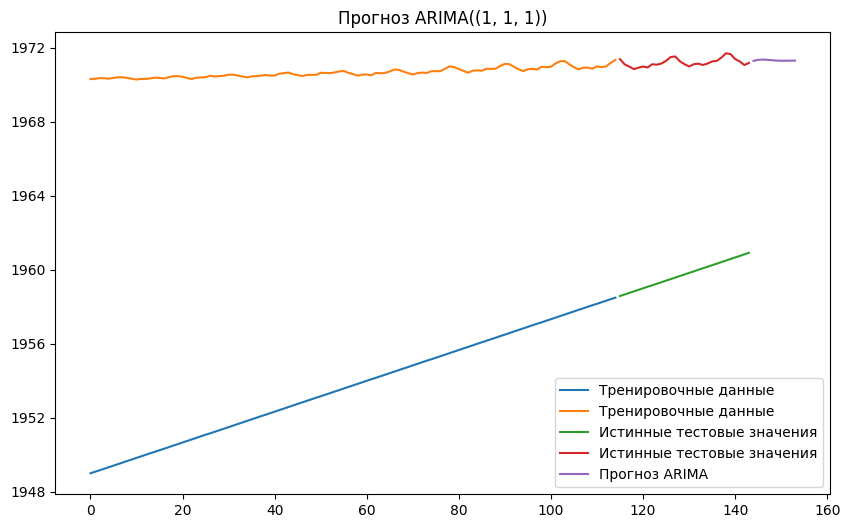

In [93]:
# Визуализация прогноза
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Тренировочные данные')
plt.plot(test_data, label='Истинные тестовые значения')
plt.plot(forecast, label='Прогноз ARIMA')
plt.title(f'Прогноз ARIMA({arima_order})')
plt.legend()
plt.show()

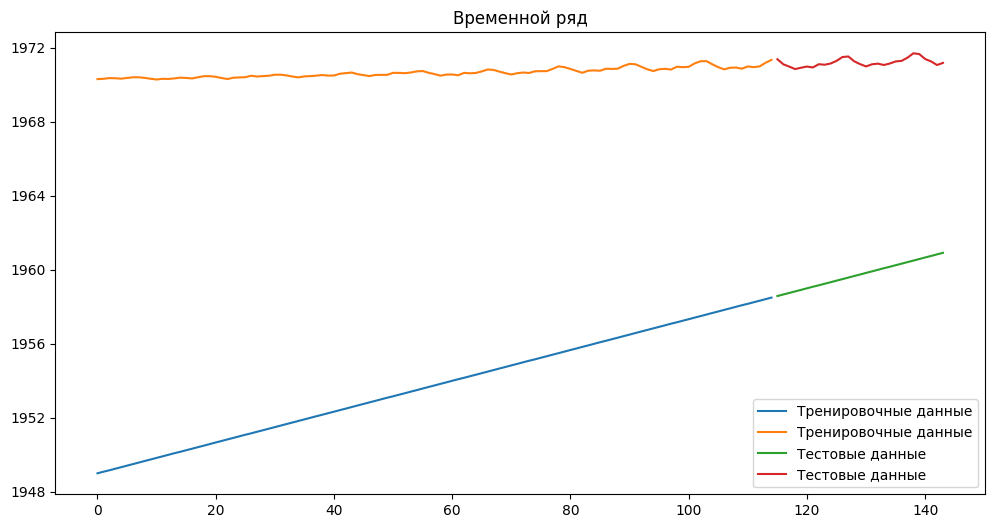

In [68]:
from sklearn.metrics import mean_squared_error

# Разделим на тренировочную и тестовую выборки
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size], data[train_size:]

# 2. Визуализация данных
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Тренировочные данные')
plt.plot(test_data, label='Тестовые данные')
plt.title('Временной ряд')
plt.legend()
plt.show()

In [86]:
# 3. Проверка на стационарность (тест Дики-Фуллера)
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dfoutput['p-value'] <= 0.05:
        print("Ряд стационарен (отвергаем нулевую гипотезу)")
    else:
        print("Ряд нестационарен (не отвергаем нулевую гипотезу)")

print("До дифференцирования:")
test_stationarity(train_data['#Passengers'])

# Если ряд нестационарен, применяем дифференцирование (d)
# Попробуем первое дифференцирование
diff_data = train_data.diff().dropna()
print("\nПосле первого дифференцирования:")
test_stationarity(diff_data['#Passengers'])

До дифференцирования:
Результаты теста Дики-Фуллера:
Test Statistic                  -0.356889
p-value                          0.917052
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
Ряд нестационарен (не отвергаем нулевую гипотезу)

После первого дифференцирования:
Результаты теста Дики-Фуллера:
Test Statistic                  -2.539635
p-value                          0.106126
#Lags Used                      13.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
Ряд нестационарен (не отвергаем нулевую гипотезу)


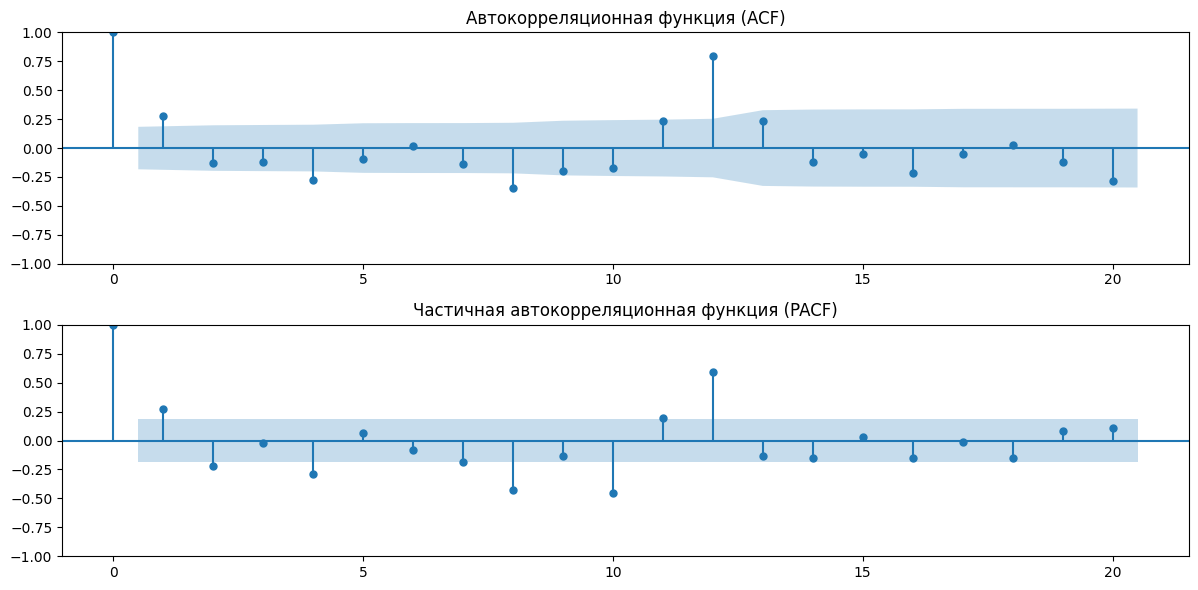

In [75]:
# 4. Идентификация параметров (p, d, q)
# Построим ACF и PACF для продифференцированного ряда
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff_data['#Passengers'], ax=plt.gca(), lags=20)
plt.title('Автокорреляционная функция (ACF)')
plt.subplot(212)
plot_pacf(diff_data['#Passengers'], ax=plt.gca(), lags=20)
plt.title('Частичная автокорреляционная функция (PACF)')
plt.tight_layout()
plt.show()

# Исходя из графиков, выбираем p и q. Для данного синтетического ряда,
# допустим, p=1, q=1.
# Таким образом, order=(p, d, q) = (1, 1, 1)

In [77]:
# 5. Построение и обучение модели ARIMA
arima_order = (1, 1, 1) # (p, d, q)
model = ARIMA(train_data['#Passengers'], order=arima_order)
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -526.123
Date:                Thu, 05 Jun 2025   AIC                           1058.246
Time:                        13:49:04   BIC                           1066.454
Sample:                             0   HQIC                          1061.577
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5111      0.114     -4.488      0.000      -0.734      -0.288
ma.L1          0.9144      0.056     16.251      0.000       0.804       1.025
sigma2       592.7851    101.208      5.857      0.0

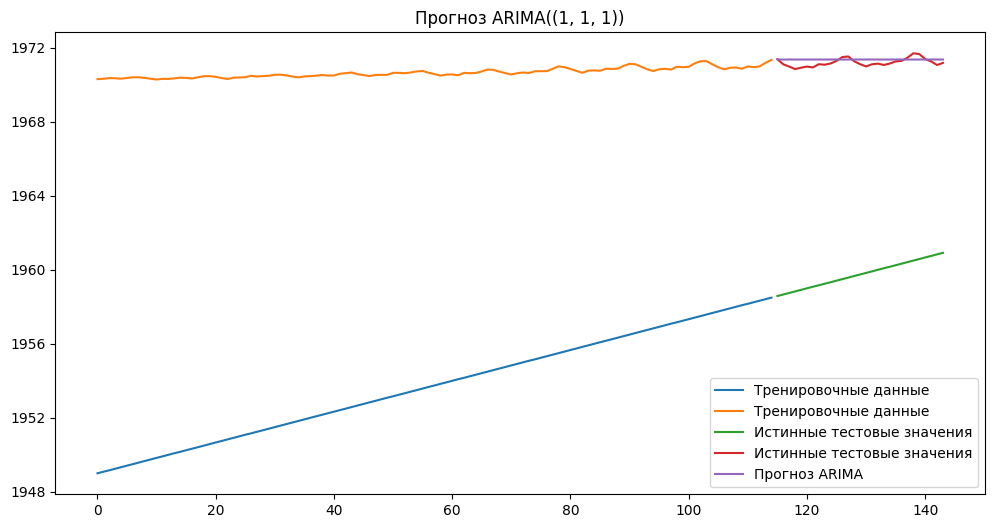

RMSE для ARIMA: 97.500


In [79]:
# 6. Прогнозирование
forecast_steps = len(test_data)
forecast = model_fit.predict(start=len(train_data), end=len(data)-1)

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Тренировочные данные')
plt.plot(test_data, label='Истинные тестовые значения')
plt.plot(forecast, label='Прогноз ARIMA')
plt.title(f'Прогноз ARIMA({arima_order})')
plt.legend()
plt.show()

# Оценка производительности (например, Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test_data['#Passengers'], forecast))
print(f'RMSE для ARIMA: {rmse:.3f}')